In [1]:
pkgs <-c('twitteR','ROAuth','httr','plyr','stringr','ggplot2','plotly')
for(p in pkgs) if(p %in% rownames(installed.packages()) == FALSE) {install.packages(p)}
for(p in pkgs) suppressPackageStartupMessages(library(p, quietly=TRUE, character.only=TRUE))

In [2]:
# Set API Keys
api_key <- "oKEgop4GPF76vRFDLvBuOhTDT"
api_secret <- "KoEeBSOfJ0FFpxZbF5rzXVRXB5Cw2ZsDFohcXNhpiQmk1WN545"
access_token <- "82004152-uBVnhbsEKPIxCuFMnI4kZMBRPOMFRFsp8mwocvPSr"
access_token_secret <- "9M3wBU9tJGqhswTtwg0JlrRHkngQAMu5wr1u2EP3XBNMM"
setup_twitter_oauth(api_key, api_secret, access_token, access_token_secret)

[1] "Using direct authentication"


In [ ]:
# Grab latest tweets
tweets_trump <- searchTwitter('@realDonaldTrump', n=3000)
tweets_sanders <- searchTwitter('@BernieSanders', n=3000)
tweets_clinton <- searchTwitter('@HillaryClinton', n=3000)
tweets_cruz <- searchTwitter('@tedcruz', n=3000)

In [ ]:
# Loop over tweets and extract text
feed_trump <- laply(tweets_trump, function(t) t$getText())
feed_sanders <- laply(tweets_sanders, function(t) t$getText())
feed_clinton <- laply(tweets_clinton, function(t) t$getText())
feed_cruz <- laply(tweets_cruz, function(t) t$getText())

In [ ]:
# Read in dictionary of positive and negative workds
yay <- scan('positive-words.txt',
                  what='character', comment.char=';')
boo <- scan('negative-words.txt',
                  what='character', comment.char=';')
# Add a few twitter-specific negative phrases
bad_text <- c(boo, 'wtf', 'wait', 'waiting',
              'epicfail', 'slow')
good_text <- c(yay, 'upgrade', ':)', '#iVoted', 'voted')

score.sentiment <- function(sentences, good_text, bad_text, .progress='none')
{
    require(plyr)
    require(stringr)
    # we got a vector of sentences. plyr will handle a list
    # or a vector as an "l" for us
    # we want a simple array of scores back, so we use
    # "l" + "a" + "ply" = "laply":
    scores = laply(sentences, function(sentence, good_text, bad_text) {
        
        # clean up sentences with R's regex-driven global substitute, gsub():
        sentence = gsub('[[:punct:]]', '', sentence)
        sentence = gsub('[[:cntrl:]]', '', sentence)
        sentence = gsub('\\d+', '', sentence)
        #to remove emojis
        sentence <- iconv(sentence, 'UTF-8', 'ASCII')
        sentence = tolower(sentence)
        
        # split into words. str_split is in the stringr package
        word.list = str_split(sentence, '\\s+')
        # sometimes a list() is one level of hierarchy too much
        words = unlist(word.list)
        
        # compare our words to the dictionaries of positive & negative terms
        pos.matches = match(words, good_text)
        neg.matches = match(words, bad_text)
        
        # match() returns the position of the matched term or NA
        # we just want a TRUE/FALSE:
        pos.matches = !is.na(pos.matches)
        neg.matches = !is.na(neg.matches)
        
        # and conveniently enough, TRUE/FALSE will be treated as 1/0 by sum():
        score = sum(pos.matches) - sum(neg.matches)
        
        return(score)
    }, good_text, bad_text, .progress=.progress )
    
    scores.df = data.frame(score=scores, text=sentences)
    return(scores.df)
}

In [ ]:
# Retreive scores and add candidate name.
thedonald <- score.sentiment(feed_trump, good_text, bad_text, .progress='text')
thedonald$name <- 'Trump'
feelthabern <- score.sentiment(feed_sanders, good_text, bad_text, .progress='text')
feelthabern$name <- 'Sanders'
clinton <- score.sentiment(feed_clinton, good_text, bad_text, .progress='text')
clinton$name <- 'Clinton'
cruz <- score.sentiment(feed_cruz, good_text, bad_text, .progress='text')
cruz$name <- 'Cruz'
# Merge into one dataframe for plotting
plotdat <- rbind(thedonald, feelthabern, clinton, cruz)
# Cut the text, just gets in the way
plotdat <- plotdat[c("name", "score")]
# Remove neutral values of 0
plotdat <- plotdat[!plotdat$score == 0, ]
# Remove anything less than -3 or greater than 3
plotdat <- plotdat[!plotdat$score > 3, ]
plotdat <- plotdat[!plotdat$score < (-3), ]

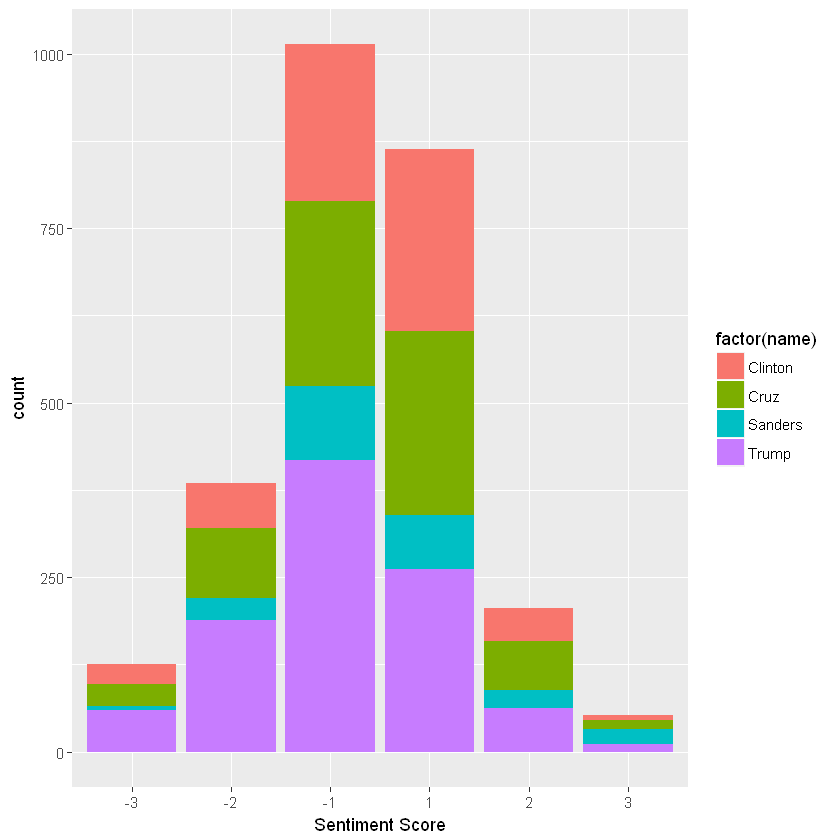

In [9]:
qplot(factor(score), data=plotdat, geom="bar", 
      fill=factor(name),
      xlab = "Sentiment Score")

List of 3
 $ axis.title.x:List of 11
  ..$ family       : NULL
  ..$ face         : chr "bold"
  ..$ colour       : chr "#000000"
  ..$ size         : num 8
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ axis.title.y:List of 11
  ..$ family       : NULL
  ..$ face         : chr "bold"
  ..$ colour       : chr "#000000"
  ..$ size         : num 10
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ axis.text.x :List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 8
  ..$ hjust        : NULL
  ..$ vjust        : num 0
  ..$ angle     

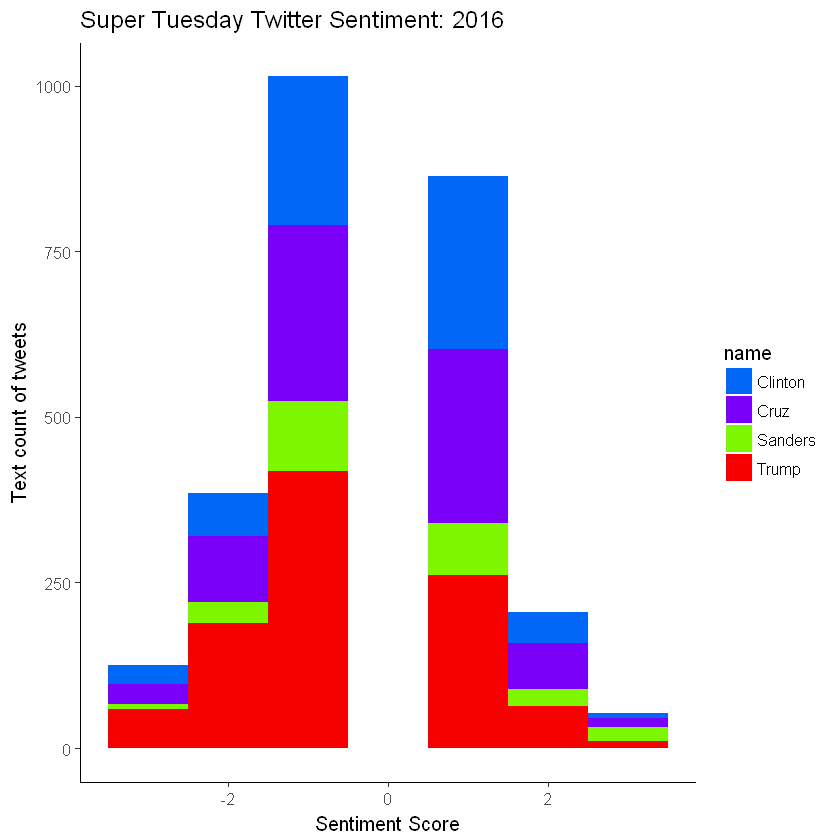

In [11]:
ep <- plotdat %>%
    ggplot(aes(x = score, fill = name)) +
    geom_histogram(binwidth = 1) +
    scale_fill_manual(values = c("#0067F7","#7B00F7", "#7CF700", "#F70000")) +
    theme_classic(base_size = 12) +
    scale_x_continuous(name = "Sentiment Score") +
    scale_y_continuous(name = "Text count of tweets") +
    ggtitle("Super Tuesday Twitter Sentiment: 2016")
    theme(axis.title.y = element_text(face="bold", colour="#000000", size=10),
          axis.title.x = element_text(face="bold", colour="#000000", size=8),
          axis.text.x = element_text(angle=16, vjust=0, size=8))
#use just ggplotly(ep) when running in R-studio

In [13]:
embed_notebook(ep)

ERROR: Error in htmlwidgets::saveWidget(l, file = basename(file)): Saving a widget with selfcontained = TRUE requires pandoc. For details see:
https://github.com/rstudio/rmarkdown/blob/master/PANDOC.md
